# Backpropagation learning for multilayer perceptrons

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv

with open('sample_data/Weather.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(f'\t In the year {row[0]}, the January temp was {row[1]}, and the February temp was {row[2]}.')
            line_count += 1
    print(f'Processed {line_count} lines.')

FileNotFoundError: ignored

#Processing Data

##Reading in Information

In [ ]:
# Need to represent cdc_week, disease, num_cases, month_avg_temp
with open('/content/drive/Shared drives/COS485 project/influenza_test.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  for row in csv_reader:
      if line_count == 0:
          print(f'Column names are {", ".join(row)}')
          line_count += 1
      elif line_count == 1:
          print(f' Season: {row[0]}, \n CDC Week: {row[1]} \n Disease: {row[2]} \n Number of Cases: {row[3]} \n Average Temp of the Month: {row[4]} \n')
          line_count += 1
  print(f'Processed {line_count} lines.')

In [ ]:
# Need to represent cdc_week, disease, num_cases, month_avg_temp
with open('/content/drive/Shared drives/COS485 project/influenza_train.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  for row in csv_reader:
      if line_count == 0:
          print(f'Column names are {", ".join(row)}')
          line_count += 1
      elif line_count == 1:
          print(f' Season: {row[0]}, \n CDC Week: {row[1]} \n Disease: {row[2]} \n Number of Cases: {row[3]} \n Average Temp of the Month: {row[4]} \n')
          line_count += 1
  print(f'Processed {line_count} lines.')

In [ ]:
# imports 
import torch
import torch.nn as nn
import torchvision
import numpy as np 
import scipy
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from IPython import display
import time


In [ ]:
# get data
## mnist = torchvision.datasets.MNIST(root='data', train=True, download=True) # train data only
## trainimages = mnist.train_data
## trainlabels = mnist.train_labels

# need some sort of structure(s) to hold train data and train labels
# structure will hold all of the datapoints
# each datapoint represents 1 week and has 3-4 facets plus the name of the week
# 0) name: label/date of the week (or week #)
# 1) number of new flu cases
# 2) number of immunizations (if we can find that data)
# 3) average temperature for the week
# 4) tourist numbers/population density increase

# Data structure
# want to make a class for a datapoint
# example: L = ['a', ['bb', ['ccc', 'ddd'], 'ee', 'ff'], 'g', 'h']

# matrix of length 10 (we have 10 seasons of data) that holds matrices
# those matrices are of length 32 (each season has 32 weeks)
# each box of THOSE matrices are Data Structures holding the features data




def get_features(i):
    """return feature vector for i'th training example"""
    im = trainimages[i].float() / 255.0 # rescale
    ft = im.view(-1) # flatten
    return ft 

def get_onehot(i):
    """return onehot label vector for i'th training example"""
    onehot = torch.zeros(10).float()
    onehot[trainlabels[i]] = 1.0
    return onehot

#Running Algorithm

In [ ]:
# Processing Dataset
import pandas as pd
from matplotlib import pyplot as plt

def get_data():
  train_data_path = '/content/drive/Shared drives/COS485 project/influenza_train.csv'
  test_data_path = '/content/drive/Shared drives/COS485 project/influenza_test.csv'
  
  train = pd.read_csv(train_data_path)
  test = pd.read_csv(test_data_path)

  return train, test

def get_combined_data():
  #reading train data
  train, test = get_data()

  train_target = train.num_cases
  train.drop(['num_cases'], axis=1, inplace = True)

  test_target = test.num_cases
  test.drop(['num_cases'], axis=1, inplace = True)

  combined = train.append(test)
  combined.reset_index(inplace=True)
  combined.drop(['season', 'index'], inplace=True, axis=1)

  return combined, train_target, test_target

train_data, test_data = get_data()
combined, train_target, test_target = get_combined_data()

In [ ]:
combined.describe()

,cdc_week,month_avg_temp
count,1029.000000,1029.000000
mean,16.620991,46.217784
std,9.565369,10.710124
min,1.000000,23.900000
25%,8.000000,37.700000
50%,16.000000,44.400000
75%,25.000000,55.000000
max,33.000000,68.500000


In [ ]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        features = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        features = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        features = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in features.columns:
        if not df[col].isnull().any():
          cols_with_no_nans.append(col)
    return cols_with_no_nans

num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

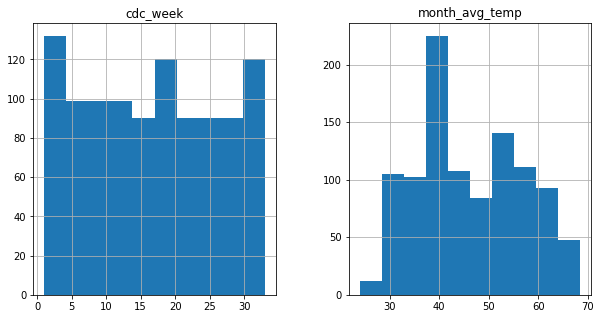

In [ ]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (10, 5))
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


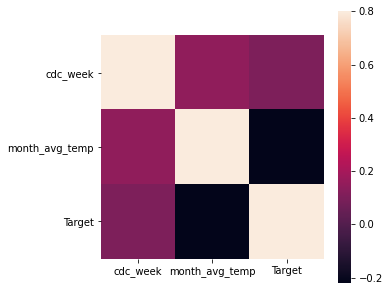

In [ ]:
import seaborn as sb

# Find correlation between features
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = train_target

C_mat = train_data.corr()
fig = plt.figure(figsize = (5,5))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [ ]:
import numpy as np

def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 3 columns before encoding categorical features
There are 5 columns after encoding categorical features


In [ ]:
combined.describe()

,cdc_week,month_avg_temp,disease_INFLUENZA_A,disease_INFLUENZA_B,disease_INFLUENZA_UNSPECIFIED
count,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000
mean,16.620991,46.217784,0.333333,0.333333,0.333333
std,9.565369,10.710124,0.471634,0.471634,0.471634
min,1.000000,23.900000,0.000000,0.000000,0.000000
25%,8.000000,37.700000,0.000000,0.000000,0.000000
50%,16.000000,44.400000,0.000000,0.000000,0.000000
75%,25.000000,55.000000,1.000000,1.000000,1.000000
max,33.000000,68.500000,1.000000,1.000000,1.000000


In [ ]:
print(len(train_data))
print(len(test_data))

792
237


In [ ]:
def split_combined():
    global combined
    num_train_ex = len(train_data)
    train = combined[:num_train_ex]
    test = combined[num_train_ex:]

    return train , test 
  
train, test = split_combined()

#Making Network: 1 Layer Linear Regression

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 

NN_model_1 = Sequential()

#Input Layer:
NN_model_1.add(Dense(128, kernel_initializer='normal', input_dim = train.shape[1], activation='relu'))

#Single Hidden Layer:
NN_model_1.add(Dense(256, kernel_initializer='normal', activation='relu'))

# The output layer:
NN_model_1.add(Dense(1, kernel_initializer='normal', activation='linear'))

# Compile the network :
NN_model_1.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model_1.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               768       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 34,049
Trainable params: 34,049
Non-trainable params: 0
_________________________________________________________________


##Checkpoint Callback

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

## Train the Model

In [ ]:
NN_model_1.fit(train, train_target, epochs=50, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 633 samples, validate on 159 samples
Epoch 1/50
633/633 [==============================] - 0s 296us/step - loss: 14.0238 - mean_absolute_error: 14.0238 - val_loss: 33.8525 - val_mean_absolute_error: 33.8525

Epoch 00001: val_loss improved from inf to 33.85254, saving model to Weights-001--33.85254.hdf5
Epoch 2/50
633/633 [==============================] - 0s 61us/step - loss: 13.7297 - mean_absolute_error: 13.7297 - val_loss: 32.6439 - val_mean_absolute_error: 32.6439

Epoch 00002: val_loss improved from 33.85254 to 32.64394, saving model to Weights-002--32.64394.hdf5
Epoch 3/50
633/633 [==============================] - 0s 58us/step - loss: 13.6909 - mean_absolute_error: 13.6909 - val_loss: 33.0655 - val_mean_absolute_error: 33.0655

Epoch 00003: val_loss did not improve from 32.64394
Epoch 4/50
633/633 [==============================] - 0s 67us/step - loss: 13.6454 - mean_absolute_error: 13.6454 - val_loss: 32.8770 - val_mean_absolute_error: 32.8770

Epoch 00004: val_loss di

In [ ]:
# Load weights file of the best model
# weights_file = 'Weights-036--29.68963.hdf5' # choose the best checkpoint 
weights_file = '/content/drive/Shared drives/COS485 project/Weights/Weights-036--29.68963.hdf5'
NN_model_1.load_weights(weights_file) # load it
NN_model_1.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

The validation loss of the best model is 29.19424



#Network 2: 2 Layers, Sigmoid and Relu

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 

NN_model_2 = Sequential()

#Input Layer:
NN_model_2.add(Dense(128, kernel_initializer='normal', input_dim = train.shape[1], activation='relu'))

#Two Hidden Layers:
NN_model_2.add(Dense(256, kernel_initializer='normal', activation='sigmoid'))
NN_model_2.add(Dense(256, kernel_initializer='normal', activation='relu'))

# The output layer:
NN_model_2.add(Dense(1, kernel_initializer='normal', activation='linear'))

# Compile the network :
NN_model_2.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               768       
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 99,841
Trainable params: 99,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_name = 'Weights-{epoch:04d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
NN_model_2.fit(train, train_target, epochs=50, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 633 samples, validate on 159 samples
Epoch 1/50
633/633 [==============================] - 0s 241us/step - loss: 13.9605 - mean_absolute_error: 13.9605 - val_loss: 33.8764 - val_mean_absolute_error: 33.8764

Epoch 00001: val_loss improved from inf to 33.87637, saving model to Weights-001--33.87637.hdf5
Epoch 2/50
633/633 [==============================] - 0s 84us/step - loss: 13.7442 - mean_absolute_error: 13.7442 - val_loss: 33.2643 - val_mean_absolute_error: 33.2643

Epoch 00002: val_loss improved from 33.87637 to 33.26434, saving model to Weights-002--33.26434.hdf5
Epoch 3/50
633/633 [==============================] - 0s 85us/step - loss: 13.5512 - mean_absolute_error: 13.5512 - val_loss: 32.6962 - val_mean_absolute_error: 32.6962

Epoch 00003: val_loss improved from 33.26434 to 32.69624, saving model to Weights-003--32.69624.hdf5
Epoch 4/50
633/633 [==============================] - 0s 84us/step - loss: 13.3662 - mean_absolute_error: 13.3662 - val_loss: 33.1132 - val_mean_

In [ ]:
# Load weights file of the best model
# weights_file = 'Weights-036--29.68963.hdf5' # choose the best checkpoint 
weights_file = '/content/drive/Shared drives/COS485 project/Weights/Weights-042--29.79151.hdf5'
NN_model_2.load_weights(weights_file) # load it
NN_model_2.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

The validation loss is 29.14336

#Network 3: 5 Layers, Sigmoid and Relu

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 

NN_model_5 = Sequential()

#Input Layer:
NN_model_5.add(Dense(128, kernel_initializer='normal', input_dim = train.shape[1], activation='relu'))

#Five Hidden Layers:
NN_model_5.add(Dense(256, kernel_initializer='normal', activation='sigmoid'))
NN_model_5.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model_5.add(Dense(256, kernel_initializer='normal', activation='sigmoid'))
NN_model_5.add(Dense(256, kernel_initializer='normal', activation='sigmoid'))
NN_model_5.add(Dense(256, kernel_initializer='normal', activation='relu'))


# The output layer:
NN_model_5.add(Dense(1, kernel_initializer='normal', activation='linear'))

# Compile the network :
NN_model_5.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               768       
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [ ]:
checkpoint_name = 'Weights-{epoch:07d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
NN_model_5.fit(train, train_target, epochs=50, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 633 samples, validate on 159 samples
Epoch 1/50
633/633 [==============================] - 0s 427us/step - loss: 14.0276 - mean_absolute_error: 14.0276 - val_loss: 34.3133 - val_mean_absolute_error: 34.3133

Epoch 00001: val_loss improved from inf to 34.31327, saving model to Weights-001--34.31327.hdf5
Epoch 2/50
633/633 [==============================] - 0s 174us/step - loss: 13.9797 - mean_absolute_error: 13.9797 - val_loss: 33.9303 - val_mean_absolute_error: 33.9303

Epoch 00002: val_loss improved from 34.31327 to 33.93026, saving model to Weights-002--33.93026.hdf5
Epoch 3/50
633/633 [==============================] - 0s 177us/step - loss: 13.8597 - mean_absolute_error: 13.8597 - val_loss: 33.2891 - val_mean_absolute_error: 33.2891

Epoch 00003: val_loss improved from 33.93026 to 33.28907, saving model to Weights-003--33.28907.hdf5
Epoch 4/50
633/633 [==============================] - 0s 179us/step - loss: 13.5754 - mean_absolute_error: 13.5754 - val_loss: 31.8107 - val_me

In [ ]:
# Load weights file of the best model
# weights_file = 'Weights-036--29.68963.hdf5' # choose the best checkpoint 
weights_file = '/content/drive/Shared drives/COS485 project/Weights/Weights-036--29.68963.hdf5'
NN_model_5.load_weights(weights_file) # load it
NN_model_5.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

ValueError: ignored

The validation loss is 28.73163

#Network 4: 10 Layers, Sigmoid and ReLu

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 

NN_model_10 = Sequential()

#Input Layer:
NN_model_10.add(Dense(128, kernel_initializer='normal', input_dim = train.shape[1], activation='relu'))

#Ten Hidden Layers:
NN_model_10.add(Dense(256, kernel_initializer='normal', activation='sigmoid'))
NN_model_10.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model_10.add(Dense(256, kernel_initializer='normal', activation='sigmoid'))
NN_model_10.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model_10.add(Dense(256, kernel_initializer='normal', activation='sigmoid'))
NN_model_10.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model_10.add(Dense(256, kernel_initializer='normal', activation='sigmoid'))
NN_model_10.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model_10.add(Dense(256, kernel_initializer='normal', activation='sigmoid'))
NN_model_10.add(Dense(256, kernel_initializer='normal', activation='relu'))


# The output layer:
NN_model_10.add(Dense(1, kernel_initializer='normal', activation='linear'))

# Compile the network :
NN_model_10.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model_10.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_16 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_18 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_21 (Dense)             (None, 256)              

In [ ]:
checkpoint_name = 'Weights-{epoch:12d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
NN_model_10.fit(train, train_target, epochs=50, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 633 samples, validate on 159 samples
Epoch 1/50
633/633 [==============================] - 0s 746us/step - loss: 14.0012 - mean_absolute_error: 14.0012 - val_loss: 34.4675 - val_mean_absolute_error: 34.4675

Epoch 00001: val_loss improved from inf to 34.46754, saving model to Weights-001--34.46754.hdf5
Epoch 2/50
633/633 [==============================] - 0s 325us/step - loss: 13.9933 - mean_absolute_error: 13.9933 - val_loss: 34.1750 - val_mean_absolute_error: 34.1750

Epoch 00002: val_loss improved from 34.46754 to 34.17497, saving model to Weights-002--34.17497.hdf5
Epoch 3/50
633/633 [==============================] - 0s 333us/step - loss: 13.9806 - mean_absolute_error: 13.9806 - val_loss: 34.2125 - val_mean_absolute_error: 34.2125

Epoch 00003: val_loss did not improve from 34.17497
Epoch 4/50
633/633 [==============================] - 0s 321us/step - loss: 13.9810 - mean_absolute_error: 13.9810 - val_loss: 34.1753 - val_mean_absolute_error: 34.1753

Epoch 00004: val_loss

The validation loss is 32.47493

In [ ]:
# Load weights file of the best model
# weights_file = 'Weights-036--29.68963.hdf5' # choose the best checkpoint 
weights_file = '/content/drive/Shared drives/COS485 project/Weights/Weights-036--29.68963.hdf5'
NN_model_10.load_weights(weights_file) # load it
NN_model_10.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

ValueError: ignored

#Misc/ NOT IN USE

In [ ]:
seasons = [] # a matrix of "weeks" matrices 
# weeks = [] # a matrix of Week objects - there will be many of these

class Week: # an object holding 3 features
  def __init__(self, weekNumber, cases, temperature):
    self.weekNumber = weekNumber
    self.cases = cases
    self.temperature = temperature

# take in data and populate seasons[] with weeks[] matrices
# and weeks[] matrices with Week objects

numberOfSeasons = len(seasons)
# seasonLength = len(weeks)
for i in range(1, numberOfSeasons) # so we start at  1, not 0
  # should be consistent across the line anyway, but just in case
  seasonLength = len(seasons[i]) 
  for j in range(1, seasonLength) # CDC numbers the weeks starting at 1
    weekNumber = j
    cases = 
    temperature = 
    w = Week(weekNumber, cases, temperature)



In [ ]:
# fn to visualize training 
def visualize_training(errsq, errcl, x0, x1, x2, W1, t):
    # convert things to numpy, numpy is easier to use with matplotlib 
    errsq, errcl, x0, x1, x2, W1 = [x.numpy() for x in [errsq, errcl, x0, x1, x2, W1]]
    
    # visualization
    avgerrsq = np.divide( np.cumsum(errsq[0:t]), np.arange(1,t+1) )
    avgerrcl = np.divide( np.cumsum(errcl[0:t]), np.arange(1,t+1) )

    fig = plt.figure(figsize=fig_size)
    gs = gridspec.GridSpec(6,5, wspace=0.3, hspace=0.1)

    ax = fig.add_subplot(gs[0,0])
    ax.axis('off')
    ax.set_title("x0 at t={}".format(t))
    ax.imshow(x0.reshape(28,28), origin='upper', interpolation='nearest') 

    ax = fig.add_subplot(gs[0,1])
    ax.bar(range(len(x1)), x1)
    ax.set_ylabel("layer1")
    ax.set_ylim((-1, 2))
    ax.grid()

    ax = fig.add_subplot(gs[0,2])
    ax.bar(range(len(x2)), x2)
    ax.set_ylabel("output")
    ax.set_ylim((-1,2))
    ax.set_xticks(range(0,10))
    ax.grid()

    ax = fig.add_subplot(gs[0,3:5])
    ax.plot(avgerrsq, label="squared")
    ax.plot(avgerrcl, label="class")
    ax.set_ylabel("error")
    ax.set_ylim([0,1])
    ax.grid()
    ax.legend()

    n1 = W1.shape[0]
    for i in range(n1):
        ax = fig.add_subplot(gs[1 + i // 5, i % 5])
        ax.axis('off')
        ax.imshow(W1.T.reshape(28,28,n1)[:,:,i], origin='upper', interpolation='nearest') 

    display.display(plt.gcf())
    time.sleep(0.01)
    display.clear_output(wait=True)
    fig.clf()
    plt.close(fig)  

In [ ]:
# functions to build and train networks 
def train_twolayer_network(f, df, eta, epsinit, tmax, fig_size):
    """Build and train two layer neural network
    
    Args:
        f: function, activation function, maps torch tensor to another torch tensor
        df: function, derivative of activation function, maps torch tensor to another torch tensor
        eta: float, learning rate
        epsinit: float, magnitude of initial weights
        tmax: int, max number of training updates
        fig_size: (x, y) size of figure to plot, may need to change to properly fit your screen
    """
    ### setup network architecture ###
    m = 60000                # number of examples in training set

    n0 = 784                 # widths of layers
    n1 = 25
    n2 = 10  

    # two fully connected synaptic layers
    W1 = epsinit*torch.randn(n1, n0)
    W2 = epsinit*torch.randn(n2, n1)

    # biases
    b1 = epsinit*torch.randn(n1)
    b2 = epsinit*torch.randn(n2)

    # training parameters
    tshow = 1000             # how often to pause for visualization
    errsq = torch.zeros(tmax) # track squared error 
    errcl = torch.zeros(tmax) # track classification error 

    ### iterate through training data ###
    for t in range(tmax):
        # get and format example
        i = int(np.floor(m*np.random.rand()))
        x0 = get_features(i)
        y = get_onehot(i)

        # forward pass
        x1 = f(torch.matmul(W1,x0) + b1)
        x2 = f(torch.matmul(W2,x1) + b2)

        # compute error 
        errsq[t] = 0.5*torch.sum((y-x2)**2)
        errcl[t] = float(np.argmax(x2.numpy()) != trainlabels[i])

        # backward pass
        delta2 = -1*(y-x2) * df(x2)
        delta1 = torch.matmul(torch.t(W2), delta2) * df(x1)

        # update weights
        W2 -= eta * torch.ger(delta2, x1) # torch.ger(x,y) means outer product of x,y
        W1 -= eta * torch.ger(delta1, x0)
        b2 -= eta * delta2
        b1 -= eta * delta1

        # visualize training 
        if t % tshow == 0: 
            visualize_training(errsq, errcl, x0, x1, x2, W1, t)
            
def train_threelayer_network(f, df, eta, epsinit, tmax, fig_size): 
    ### Your code here ###
    raise NotImplementedError

In [ ]:
### Train 2-layer perceptron with sigmoid activation ###
def f(x):
    return 1 / (1+torch.exp(-x))
def df(y):
    return y * (1-y)
eta = 0.1 # learning rate 
epsinit = 0.01 #initial scale of weights
tmax = int(6*10**5) # number of training iterations 
fig_size = (20,20) # size of figure, may need to modify to make plots fit screen

train_twolayer_network(f, df, eta, epsinit, tmax, fig_size)

**Autograd**

In [ ]:
# autograd version of two layer network
def train_twolayer_network_autograd(f, eta, epsinit, tmax, fig_size):
    """Build and train two layer neural network
    
    Args:
        f: function, activation function, maps torch tensor to another torch tensor
        eta: float, learning rate
        epsinit: float, magnitude of initial weights
        tmax: int, max number of training updates
        fig_size: (x, y) size of figure to plot, may need to change to properly fit your screen
    """
    ### setup network architecture ###
    m = 60000                # number of examples in training set

    n0 = 784                 # widths of layers
    n1 = 25
    n2 = 10  

    # two fully connected synaptic layers
    W1 = nn.Parameter(epsinit*torch.randn(n1, n0))
    W2 = nn.Parameter(epsinit*torch.randn(n2, n1))

    # biases
    b1 = nn.Parameter(epsinit*torch.randn(n1))
    b2 = nn.Parameter(epsinit*torch.randn(n2))
    
    # create optimizer
    optim = torch.optim.SGD([W1,W2,b1,b2], eta)

    # training parameters
    tshow = 1000             # how often to pause for visualization
    errsq = torch.zeros(tmax) # track squared error 
    errcl = torch.zeros(tmax) # track classification error 

    ### iterate through training data ###
    for t in range(tmax):
        # get and format example
        i = int(np.floor(m*np.random.rand()))
        x0 = get_features(i)
        y = get_onehot(i)
        
        # zero gradients, without this, pytorch will add new grads to previous ones
        optim.zero_grad()

        # forward pass
        x1 = f(torch.matmul(W1,x0) + b1)
        x2 = f(torch.matmul(W2,x1) + b2)

        # compute error 
        e = 0.5*torch.sum((y-x2)**2)
        errsq[t] = e
        errcl[t] = float(np.argmax(x2.detach().numpy()) != trainlabels[i])

        # backward pass
        e.backward()

        # update weights
        optim.step()

        # visualize training 
        if t % tshow == 0: 
            visualize_training(errsq.detach(), errcl.detach(), x0.detach(), x1.detach(), x2.detach(), W1.detach(), t)

In [ ]:
### Train 2-layer perceptron with sigmoid activation ###
def f(x):
    return 1 / (1+torch.exp(-x))

eta = 0.1 # learning rate 
epsinit = 0.01 #initial scale of weights
tmax = int(6*10**5) # number of training iterations 
fig_size = (20,20) # size of figure, may need to modify to make plots fit screen

train_twolayer_network_autograd(f, eta, epsinit, tmax, fig_size)